In [1]:
# implement https://arxiv.org/pdf/1705.08690.pdf on avalanche framework on permuted MNIST
# https://aahaanmaini.medium.com/mimicking-human-continual-learning-in-a-neural-network-c15e1ae11d70
#continual learning

## create naive and deepgen models

In [2]:
from torch import nn
from avalanche.models import SimpleMLP

#Naive approach
model_naive = SimpleMLP(num_classes=10, hidden_size = 400, hidden_layers=2)

#Continual Learning approach
model_cl_scholar = SimpleMLP(num_classes=10, hidden_size = 400, hidden_layers=2)


c:\Users\mathi\Anaconda3\envs\DL2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\mathi\Anaconda3\envs\DL2\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


## create GAN

In [31]:
#https://github.com/znxlwm/pytorch-MNIST-CelebA-GAN-DCGAN/blob/master/pytorch_MNIST_GAN.py
import matplotlib.pyplot as plt
import itertools
import pickle
#import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, input_size=32, n_class = 10):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, 512)
        self.fc3 = nn.Linear(self.fc2.out_features, 1024)
        self.fc4 = nn.Linear(self.fc3.out_features, n_class)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.fc1(input), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.tanh(self.fc4(x))

        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, input_size=32, n_class=10):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, 512)
        self.fc3 = nn.Linear(self.fc2.out_features, 256)
        self.fc4 = nn.Linear(self.fc3.out_features, n_class)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.fc1(input), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.sigmoid(self.fc4(x))

        return x

fixed_z_ = torch.randn((5 * 5, 100))    # fixed noise
fixed_z_ = Variable(fixed_z_, volatile=True)

# training parameters
batch_size = 128
lr = 0.0002
train_epoch = 100

# data_loader
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
# network
G = generator(input_size=100, n_class=28*28)
D = discriminator(input_size=28*28, n_class=1)

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)


c:\Users\mathi\Anaconda3\envs\DL2\lib\site-packages\ipykernel_launcher.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


In [4]:
from avalanche.benchmarks.classic import SplitMNIST
from avalanche.models import SimpleMLP

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
# create transform to grayscale
transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
])
# CL Benchmark Creation
BM = SplitMNIST(n_experiences=5, seed=12345, train_transform=transform, eval_transform=transform)


In [78]:
from torch.utils.data import DataLoader
from tqdm import tqdm
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
for experience in BM.train_stream:
    print('training experience', experience.current_experience)
    print('training classes', experience.classes_in_this_experience)
    train_loader = DataLoader(experience.dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(train_epoch):
        D_losses = []
        G_losses = []
        for x_, _, _ in tqdm(train_loader):
            D.zero_grad()
            # convert x_ to tensor
            #x_ = torch.tensor(x_).view(-1, 28 * 28)
            x_ = x_.view(-1, 28 * 28)
            mini_batch = x_.size()[0]
            y_real_ = torch.ones(mini_batch,1)
            y_fake_ = torch.zeros(mini_batch,1)

            x_, y_real_, y_fake_ = Variable(x_), Variable(y_real_), Variable(y_fake_)

            D_result = D(x_)
            D_real_loss = BCE_loss(D_result, y_real_)
            D_real_score = D_result

            z_ = torch.randn(mini_batch, 100)
            z_ = Variable(z_)
            G_result = G(z_)

            D_result = D(G_result)
            D_fake_loss = BCE_loss(D_result, y_fake_)
            D_fake_score = D_result

            D_train_loss = D_real_loss + D_fake_loss

            D_train_loss.backward()
            D_optimizer.step()

            D_losses.append(D_train_loss.data)

            # train generator G
            G.zero_grad()

            z_ = torch.randn(mini_batch, 100)
            y_ = torch.ones(mini_batch, 1)

            z_, y_ = Variable(z_), Variable(y_)
            G_result = G(z_)
            D_result = D(G_result)
            G_train_loss = BCE_loss(D_result, y_)
            G_train_loss.backward()
            G_optimizer.step()

            G_losses.append(G_train_loss.data)

        print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch + 1), train_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    

    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))



training experience 0
training classes [0, 7]


  0%|          | 0/96 [00:00<?, ?it/s]c:\Users\mathi\Anaconda3\envs\DL2\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
c:\Users\mathi\Anaconda3\envs\DL2\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
 48%|████▊     | 46/96 [00:09<00:10,  4.90it/s]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


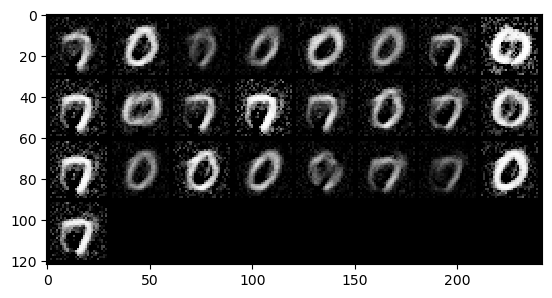

In [77]:
from matplotlib import pyplot as plt
import torchvision
# create a grid of 5x5 images
G.eval()
fixed_z_ = torch.randn((5 * 5, 100))    # fixed noise
test_images = G(fixed_z_)
test_images = test_images.view(test_images.size(0), 1, 28, 28)
test_images = test_images.data
grid = torchvision.utils.make_grid(test_images)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()


In [16]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from avalanche.training.supervised import Naive
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics

optimizer = SGD(model_naive.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()


# Continual learning strategy
cl_strategy_naive = Naive(
    model_naive, optimizer, criterion, train_mb_size=32, train_epochs=2, 
    eval_mb_size=32)

# model_cl_scholar strategy
cl_strategy_scholar = Naive(
    model_cl_scholar, optimizer, criterion, train_mb_size=32, train_epochs=2,
    eval_mb_size=32)

In [36]:
#train naive model on train stream
#train GAN on 50% train stream data and 50% generated data
#train CL on 50% GAN generated data and 50% train stream data

results = []
tasks_learned_so_far = []

# iterating over the train stream
for experience in BM.train_stream:
    print('Tasks learned so far:', experience.classes_seen_so_far)    

    #train naive model on train stream
    cl_strategy_naive.train(experience, verbose=0)
    #test naive model on test stream
    naive_evaluation = cl_strategy_naive.eval(BM.test_stream)

    #train GAN on 50% train stream data and 50% generated data
    #train CL on 50% GAN generated data and 50% train stream data
    if experience.task_label == 0:
        #train gan only first task
        gan.fit(experience, verbose=0)
        combined_data = experience
    else:
        new_data = gan.generate()
        combined_data = np.concatenate((experience, new_data), axis=0)
        #sample 50% of combined data
        combined_data = np.random.choice(combined_data, size=combined_data.shape[0]//2, replace=False)
        
    cl_strategy_scholar.train(combined_data, verbose=0)

Tasks learned so far: [0, 7]
-- >> Start of training phase << --
662it [01:52,  5.86it/s]                         
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0616
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9829
100%|██████████| 381/381 [00:08<00:00, 42.95it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0149
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9951
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 63/63 [00:01<00:00, 52.28it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0136
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9960
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 66/66 [00:01<00:00, 44.13it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 1.0057
	Top1_Ac